## Task 05: Trees and Ensembles (2022-04-19)

Apply the same procedure with randomized search and cross-validation to obtain decision trees and random forest models.

To that end, add to your previous code the new models on sklearn and the respective hyperparameters

In [1]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [2]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# task 03
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# task 05
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#allow to print all variables in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from scipy import stats


### Opening data file and Separating parameters and labels

In [3]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)


### Building AR Model

In [4]:
modelOrder = 30

x2 = dataset[:,1,:].transpose() # acelerômetro: base
x3 = dataset[:,2,:].transpose() # acelerômetro: 1o andar
x4 = dataset[:,3,:].transpose() # acelerômetro: 2o andar
x5 = dataset[:,4,:].transpose() # acelerômetro: 3o andar

x2r = [] 
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x5r.append(res.params)

X1 = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
X1.shape

(850, 120)

### PCA analysis

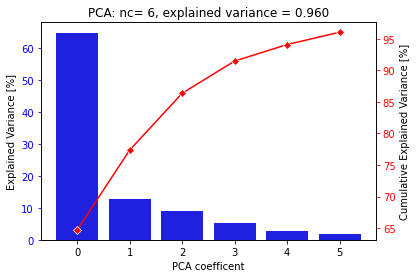

In [5]:
nComponents = 0.95  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X1)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i for i in range(len(pcaVariances))]

ax = sns.barplot(pcaComponents, pcaVariances*100, color='b');
ax2 = ax.twinx()
ax2 = sns.lineplot(pcaComponents, np.cumsum(pcaVariances)*100, color='r', marker='D');
ax.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: nc= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5])
ax.set_xlabel('PCA coefficent')
ax.set_ylabel('Explained Variance [%]')
ax2.set_ylabel('Cumulative Explained Variance [%]')
pass;

### Building x2 by transforming the x1 data with the previous PCA model and scaling X2

In [6]:
X2 = pca.fit_transform(X1)
X1_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X1)
X2_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X2)

### Creating pandas dataframe versions of the scaled x and x2, adding their labels

In [7]:
dfx1 = pd.DataFrame(X1_scaled)
dfx1 = dfx1.copy()
dfx1['label'] = y

dfx2 = pd.DataFrame(X2_scaled)
dfx2 = dfx2.copy()
dfx2['label'] = y

###  1. Split your dataset into a) training/validation and b) test datasets (e.g. 60/40% ratio split)

In [98]:
# From now on we dont use the '_scaled' for the test and train ensemples anymore
test_size = 0.40

X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=test_size, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=test_size, random_state=10)

### Softmax Linear Model (logistic regression with multiple classes) for the PCA reduced database

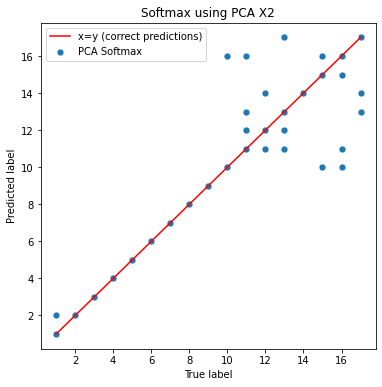

In [99]:
#PCA SOFTMAX
model_PCA_Soft = LogisticRegression(multi_class='multinomial', max_iter=200).fit(X2_train, y_train)

yPred2_train = model_PCA_Soft.predict(X2_train)
yPred2_test = model_PCA_Soft.predict(X2_test)

fig = plt.figure(figsize=(6, 6));
x=np.arange(1,18,1);

ax = sns.scatterplot(y_test,yPred2_test, s=50);
ax.set_xlabel('True label');
ax.set_ylabel('Predicted label');
ax=sns.lineplot(x=x, y=x, color='r');
ax.legend(['x=y (correct predictions)','PCA Softmax']);

ax.set_title('Softmax using PCA X2');

___

### Adding Decision Trees to the previous SVM and k-NN models eith their default params, then saving it to a results Dataframe

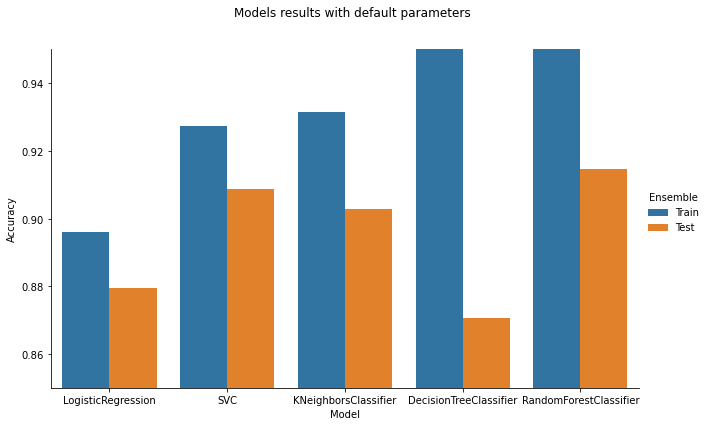

In [100]:
# Previous Model Softmax PCA
dfResults = pd.DataFrame({
        'Model': ['LogisticRegression'], 
        'Hyperparam': ['Default'], 
        'Train': accuracy_score(y_train, yPred2_train), 
        'Test': accuracy_score(y_test, yPred2_test)
        })

for i,model in enumerate([SVC(),KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]):
    modelTrained = model.fit(X2_train, y_train)
    
    yPred_train = modelTrained.predict(X2_train)
    yPred_test = modelTrained.predict(X2_test)

    dfResults = dfResults.append(pd.DataFrame({
        'Model': [str(model).split('(')[0]],
        'Hyperparam': ['Default'], 
        'Train': accuracy_score(y_train, yPred_train), 
        'Test': accuracy_score(y_test, yPred_test)
        }))

# unpivot dfResults in case of plotting graphs
dfResultsPlot = dfResults.melt(id_vars=['Model', 'Hyperparam'], value_name='Accuracy', var_name='Ensemble')

ax = sns.catplot(x='Model', y='Accuracy', hue='Ensemble', data=dfResultsPlot, kind="bar", height=6, aspect=1.5);
ax.set(ylim=(0.85, .95));
ax.fig.subplots_adjust(top=.88) # adjust the Figure in rpxax
ax.fig.suptitle('Models results with default parameters');
# plt.xticks(rotation=0)
pass;

As the trees have a lot of hyperparams, its quite usual to have overfitting on them.

We Note that so far the Decision Tree Classifier has the worst generalization error, although it has the best training score.

As we use a Rnadom Forest Classifier, the accuracy is increased and turns to be the best model so far with default hyperparameters


### 2. Use randomized search with repeated cross-validation for hyperparameter tuning. Use e.g. 

    A. n_splits = 5, n_repeats = 50 [RepeatedKFold]


In [101]:
k_folds = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=10)

rkf

RepeatedKFold(n_repeats=50, n_splits=5, random_state=10)


    B. n_iter = 100, n_jobs = -1 (will use all your cores), cv = (object you created with RepeatedKFold in 2.A), scoring = (choose a performance metric for classification problems), [RandomizedSearchCV]

    C. Suggestion: create estimator in a list and a list of dictionaries for param_distributions, as shown in the slides [RandomizedSearchCV]


In [102]:
n_iter = 100
n_jobs = -1
scoring = 'accuracy'

param_grids = []
param_grids.append([# SoftMax = 0
        {
            'penalty':  ['l2', 'none'],
            'C':    stats.randint(1,10), # def=1
            'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
        }])
param_grids.append([# SVC = 1
        {
            'C':  stats.randint(1,15), # def=1
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # excluded 'precomputed' cause it demands a square X matrix, not the case
            'degree': stats.randint(1,10), # def = 3
            'gamma': ['scale','auto']
        }])
param_grids.append([# KNN = 2
        {
            'n_neighbors':  stats.randint(3,11), # def = 5
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
            'leaf_size': stats.randint(1,50) #def = 30            
        }])

# Adding Decision Trees and Random Forests
param_grids.append([# Decision Trees = 3
        {
            # 'criterion':  ['gini', 'entropy'], # d= gini
            # 'splitter':  ['best', 'random'], # d= best
            'max_features':  stats.uniform(), # d= None
            'max_depth':  stats.randint(3,20), # def = None

        }])
param_grids.append([# Random Forest = 4
        {
            'n_estimators': stats.randint(2,50), # d= gini
            # 'criterion':  ['gini', 'entropy'], # d= gini
            'max_features':  stats.uniform(), # d= None
            'max_depth':  stats.randint(2,30), # def = None            
        }])

models = [LogisticRegression(multi_class='multinomial'), SVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]

### Performing a randomized search for hyperparameters

In [104]:
rscv_results = []
for k in tqdm(range(len(models))):
    random_search = RandomizedSearchCV(models[k], verbose=0, scoring=scoring, param_distributions=param_grids[k], n_iter=n_iter, n_jobs=n_jobs, cv=rkf, random_state=10);
    random_search.fit(X2_train, y_train)

    # saving rscv instance...
    rscv_results.append(random_search)

  0%|          | 0/5 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=10),
                   estimator=LogisticRegression(multi_class='multinomial'),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E35B6E6A0>,
                                         'penalty': ['l2', 'none'],
                                         'solver': ['newton-cg', 'sag', 'saga',
                                                    'lbfgs']}],
                   random_state=10, scoring='accuracy')

 20%|██        | 1/5 [17:20<1:09:20, 1040.04s/it]

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=10),
                   estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E2EF583D0>,
                                         'degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E35D158B0>,
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']}],
                   random_state=10, scoring='accuracy')

 40%|████      | 2/5 [18:32<37:28, 749.64s/it]   

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=10),
                   estimator=KNeighborsClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'algorithm': ['auto', 'ball_tree',
                                                       'kd_tree', 'brute'],
                                         'leaf_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E35B6EDF0>,
                                         'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E2EF58790>}],
                   random_state=10, scoring='accuracy')

 60%|██████    | 3/5 [19:51<18:16, 548.46s/it]

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=10),
                   estimator=DecisionTreeClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E32900A30>,
                                         'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E32900B80>}],
                   random_state=10, scoring='accuracy')

 80%|████████  | 4/5 [20:23<06:33, 393.55s/it]

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=50, n_splits=5, random_state=10),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E35B6E370>,
                                         'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E35C8ABE0>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021E2EF58190>}],
                   random_state=10, scoring='accuracy')

100%|██████████| 5/5 [30:41<00:00, 368.28s/it]


In [105]:
for rscv in rscv_results:
    rscv.best_estimator_
    # rscv.best_params_
    
    y_hat = rscv.predict(X2_test)
           
    dfResults = dfResults.append(pd.DataFrame({
        'Model': [str(rscv.best_estimator_).split('(')[0]],
        'Hyperparam': 'RandomSearch', 
        'Train': rscv.best_score_, 
        'Test': accuracy_score(y_hat, y_test)
        }))


LogisticRegression(C=6, multi_class='multinomial', penalty='none')

SVC(C=10, degree=2, kernel='poly')

KNeighborsClassifier(leaf_size=43, n_neighbors=3)

DecisionTreeClassifier(max_depth=19, max_features=0.8664916406550097)

RandomForestClassifier(max_depth=27, max_features=0.3971645228775721,
                       n_estimators=47)

In [106]:
dfResults

,Model,Hyperparam,Train,Test
0,LogisticRegression,Default,0.896078,0.879412
0,SVC,Default,0.927451,0.908824
0,KNeighborsClassifier,Default,0.931373,0.902941
0,DecisionTreeClassifier,Default,1.000000,0.870588
0,RandomForestClassifier,Default,1.000000,0.914706
0,LogisticRegression,RandomSearch,0.932392,0.920588
0,SVC,RandomSearch,0.925255,0.932353
0,KNeighborsClassifier,RandomSearch,0.896078,0.905882
0,DecisionTreeClassifier,RandomSearch,0.866039,0.882353
0,RandomForestClassifier,RandomSearch,0.906510,0.914706


### Note
For the train score we considered the property "best_score_" of the objects of the class RandomSearchCV that is a score average in the k-fold validation process

As in the default parameters set we have trained the models directly using the X2 train_test_split returned matrix, we think that this Train score is no longer a good comparison. So we will use only the Test score to compare them

### Results and Discussion

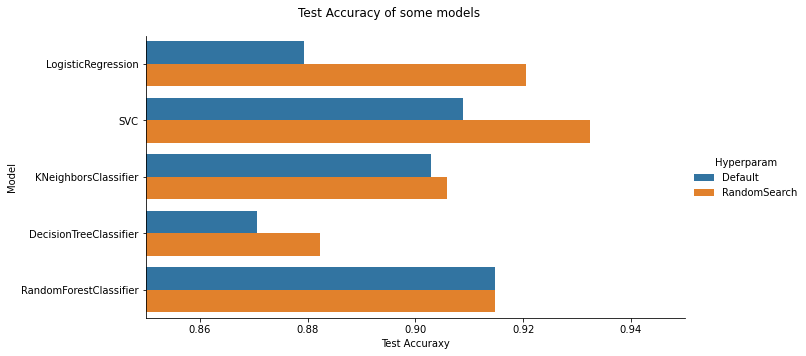

In [107]:
ax = sns.catplot(x="Test", hue="Hyperparam", y="Model", data=dfResults, kind='bar', height=5, aspect=2, legend_out=True, margin_titles=False);
ax.set_xlabels("Test Accuraxy")
ax.fig.suptitle("Test Accuracy of some models")
ax.fig.subplots_adjust(top=0.9)
ax.set(xlim=(0.85, .95));
pass;

### Comments:

1. In general we see some improve in the quality of all models when tunning their hyperparameters with the Random Search class;

2. Decistion Tree Classifier has the poorer score, while the Random Forest performs much better. That shows the power of ensembles;

3. SVM classifier is still the best one using random search for hyperparameters;

4. Random Forest has the best score with the default hyperparameters, but showed no gain of accuracy when tunning them with random search

5. The search for parameters took a lot of CPU time in each iteraction (about 30 minutes). This has complicated a little bit the procedure to optimize the hyperparameters range in the random search.